In [82]:
# Import Torch
import torch
from torch import nn

# Import Torchvision
import torchvision
from torchvision import datasets 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Other
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [83]:
# HYPERPARAMETERS
EPOCHS = 12
BATCH_SIZE = 64
LEARNING_RATE = 0.1
RANDOM_SEED = 142

CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [84]:

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} deivce")

Using cuda deivce


### Data Preparation

* **Normalization:** I calculated the specific mean and standard deviation directly from the training data. These values were used to normalize the inputs to a centered range, improving model convergence speed.
* **Resizing:** This step was skipped as the dataset consists of uniformly sized images (28x28) that already match the model's input requirements.
* **Data Augmentation:** I decided against augmentations like rotations or flips. Since FashionMNIST images are pre-centered and strictly aligned (e.g., shoes are always flat, shirts are upright), preserving this consistency allows the model to learn features more effectively than introducing artificial variance.

In [85]:
# GET TRAIN DATASET
train_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

# CALCULATE MEAN & STD
imgs = train_data.data.float() / 255.0  # Scale 0-255 integers to 0-1 floats (the row data)
mean = imgs.mean().item()
std = imgs.std().item()

print(f"Calculated Mean: {mean:.4f}")
print(f"Calculated Std:  {std:.4f}")

# NORMALIZE TRAIN DATA
normalization = transforms.Compose([
    ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_data.transform = normalization

Calculated Mean: 0.2860
Calculated Std:  0.3530


In [86]:
# GET TEST DATASET
test_data = datasets.FashionMNIST(
    root="../data", 
    train=False,  
    download=True,
    transform=normalization, 
)

# CREATE DATALOADERS
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False)

### Model Architecture

I implemented a CNN based on the TinyVGG architecture with two main components:

* **Convolutional Blocks:** Two sequential blocks, each containing two `Conv2d` layers (10 filters, 3x3 kernel) followed by `ReLU` activation and `MaxPool2d`. This structure extracts features while reducing image dimensions from $28\times28$ to $7\times7$.
* **Classifier:** A final fully connected (`Linear`) layer that flattens the feature maps ($7 \times 7 \times 10$) and maps them directly to the 10 output classes.

In [87]:
# BUILD MODEL
class FashionMNISTModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,  # Number of input channels, 1 for grayscale images.
                      out_channels=10,  # Number of filters (feature maps).
                      kernel_size=3,  
                      stride=1,  
                      padding=1  
            ),  
            nn.ReLU(),  
            nn.Conv2d(in_channels=10,
                      out_channels=10,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Window size of (2, 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=10,
                      out_channels=10,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=10,
                      out_channels=10,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*10, # Need to find this nunber with testing with randn tensore in same shape as the images in dataset
                      out_features=10  # Num Labels we have
            )
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(f"Output shape of conv block 1: {x.shape}")
        x = self.conv_block_2(x)
        #print(f"Output shape of conv block 2: {x.shape}")
        x = self.classifier(x)
        return x


torch.manual_seed(RANDOM_SEED)
FashionModel = FashionMNISTModelV2()
FashionModel.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### Training and Evaluation Setup

I established a complete training pipeline consisting of the following components:

* **Optimization:** Used **CrossEntropyLoss** for multi-class classification and **SGD** as the optimizer.
* **Learning Rate Scheduler:** Implemented `StepLR` to decay the learning rate by a factor of 0.5 every 3 epochs to improve fine-tuning as the model converges.
* **Training & Testing Loops:** Defined modular `train_step` and `test_step` functions. The training loop handles the forward pass, loss calculation, backpropagation, and weight updates, while the testing loop evaluates the model on unseen data in `inference_mode`.

In [88]:
# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

# OPTIMIZER
optimizer = torch.optim.SGD(params=FashionModel.parameters(), lr=LEARNING_RATE)

# SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# ACCURACY FUNCTION
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,  y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [89]:

# TRAINING LOOP FUNCTION
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    # Put model in training mode
    model.train()
    # Initialize train loss and train acc
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(tqdm(data_loader)):
        # Moving batch images and label to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (get logitis)
        y_pred = model(X)

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # Convert y_pred from logitis to predict label to calc acc 
        
        # 3. optimizer zero
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Devide train_loass and train_acc in num batch to get average loss, acc per batch
    train_loss /= len(data_loader) 
    train_acc /= len(data_loader)
    print(f"| Train Loss: {train_loss:.5f} Train accuracy: {train_acc:.4f}% |")

    return train_loss, train_acc

# TEST LOOP FUNCTION
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.dataloader,
              loss_fn: torch.nn.Module, 
              accuracy_fn,
              device: torch.device = device):

    """Perform Test loop on dataloader"""

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Moving batch images and label to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(y_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # input is label and not logits
 
        # Get average test loss and avarge accuracy per batch
        test_loss /= len(data_loader)  # Total loss is not a regular int and this line have to be insid the inference mode.
        test_acc /= len(data_loader)

    print(f"| Test loss: {test_loss:.5f} Test acc: {test_acc:.4f}% |\n")

    return test_loss, test_acc

In [90]:
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch} --------")

    train_loss, train_acc = train_step(model=FashionModel,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_loss, test_acc = test_step(model=FashionModel,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

    scheduler.step()
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

Epoch: 0 --------


100%|██████████| 938/938 [00:11<00:00, 83.26it/s]


| Train Loss: 0.58972 Train accuracy: 78.7447% |


100%|██████████| 157/157 [00:01<00:00, 86.17it/s] 


| Test loss: 0.44053 Test acc: 83.1907% |

Current Learning Rate: 0.1
Epoch: 1 --------


100%|██████████| 938/938 [00:11<00:00, 83.95it/s]


| Train Loss: 0.35060 Train accuracy: 87.3984% |


100%|██████████| 157/157 [00:01<00:00, 96.07it/s] 


| Test loss: 0.38814 Test acc: 86.1764% |

Current Learning Rate: 0.1
Epoch: 2 --------


100%|██████████| 938/938 [00:10<00:00, 85.41it/s]


| Train Loss: 0.30666 Train accuracy: 88.9526% |


100%|██████████| 157/157 [00:01<00:00, 100.00it/s]


| Test loss: 0.32827 Test acc: 88.7241% |

Current Learning Rate: 0.05
Epoch: 3 --------


100%|██████████| 938/938 [00:11<00:00, 84.91it/s]


| Train Loss: 0.26486 Train accuracy: 90.4734% |


100%|██████████| 157/157 [00:01<00:00, 117.07it/s]


| Test loss: 0.28540 Test acc: 89.6596% |

Current Learning Rate: 0.05
Epoch: 4 --------


100%|██████████| 938/938 [00:12<00:00, 76.27it/s]


| Train Loss: 0.25405 Train accuracy: 90.8249% |


100%|██████████| 157/157 [00:01<00:00, 93.42it/s]


| Test loss: 0.27884 Test acc: 90.0478% |

Current Learning Rate: 0.05
Epoch: 5 --------


100%|██████████| 938/938 [00:11<00:00, 80.71it/s]


| Train Loss: 0.24726 Train accuracy: 91.1381% |


100%|██████████| 157/157 [00:01<00:00, 108.12it/s]


| Test loss: 0.28237 Test acc: 89.4904% |

Current Learning Rate: 0.025
Epoch: 6 --------


100%|██████████| 938/938 [00:11<00:00, 84.06it/s]


| Train Loss: 0.22931 Train accuracy: 91.7194% |


100%|██████████| 157/157 [00:01<00:00, 111.11it/s]


| Test loss: 0.26604 Test acc: 90.1075% |

Current Learning Rate: 0.025
Epoch: 7 --------


100%|██████████| 938/938 [00:11<00:00, 84.60it/s]


| Train Loss: 0.22473 Train accuracy: 91.9143% |


100%|██████████| 157/157 [00:01<00:00, 112.73it/s]


| Test loss: 0.26704 Test acc: 90.2369% |

Current Learning Rate: 0.025
Epoch: 8 --------


100%|██████████| 938/938 [00:10<00:00, 85.51it/s]


| Train Loss: 0.22100 Train accuracy: 92.0442% |


100%|██████████| 157/157 [00:01<00:00, 97.02it/s] 


| Test loss: 0.25974 Test acc: 90.7544% |

Current Learning Rate: 0.0125
Epoch: 9 --------


100%|██████████| 938/938 [00:10<00:00, 85.31it/s]


| Train Loss: 0.21212 Train accuracy: 92.3707% |


100%|██████████| 157/157 [00:01<00:00, 117.54it/s]


| Test loss: 0.25310 Test acc: 90.7046% |

Current Learning Rate: 0.0125
Epoch: 10 --------


100%|██████████| 938/938 [00:10<00:00, 85.72it/s]


| Train Loss: 0.21002 Train accuracy: 92.4740% |


100%|██████████| 157/157 [00:01<00:00, 96.31it/s] 


| Test loss: 0.25449 Test acc: 90.8838% |

Current Learning Rate: 0.0125
Epoch: 11 --------


100%|██████████| 938/938 [00:11<00:00, 83.94it/s]


| Train Loss: 0.20816 Train accuracy: 92.5107% |


100%|██████████| 157/157 [00:01<00:00, 107.86it/s]

| Test loss: 0.25495 Test acc: 90.9534% |

Current Learning Rate: 0.00625


### Model Evaluation & Visualization

* **Training Curves:** I plotted loss and accuracy over time to verify convergence and check for overfitting.
* **Performance Metrics:** I generated a Classification Report and Confusion Matrix to identify specific classes where the model makes errors (e.g., confusing "Shirt" with "T-shirt").
* **Internal Visualizations:** I visualized the learned **Filters** (kernels) and **Feature Maps** to understand how the CNN extracts edges and patterns from the input images.

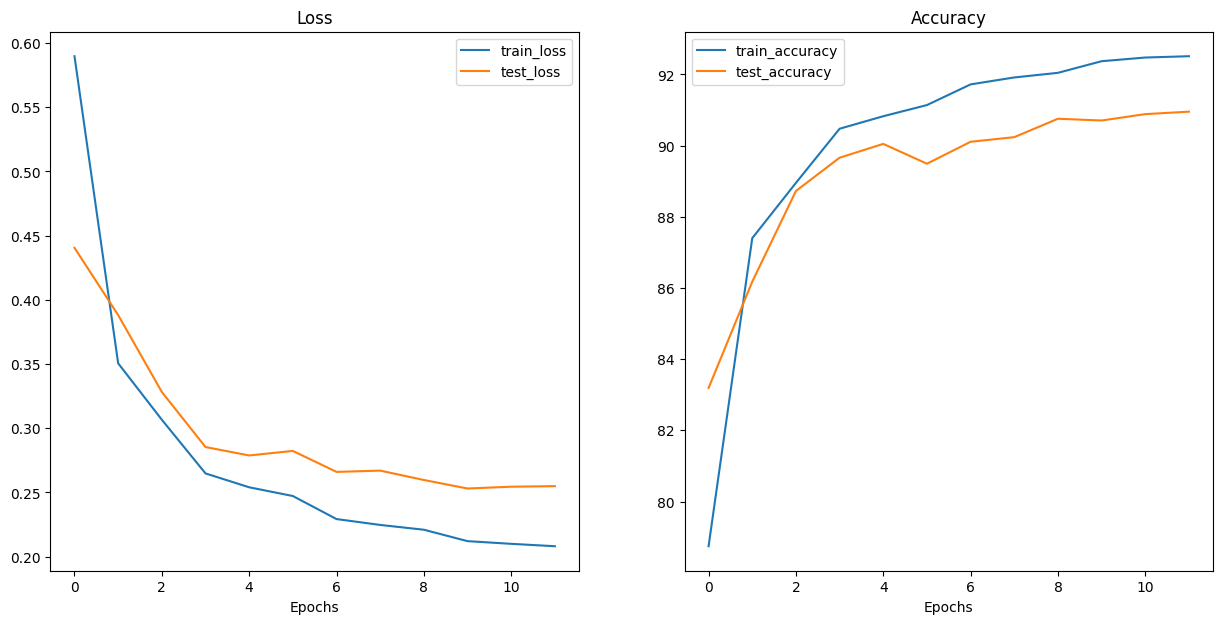

In [91]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary."""
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Setup the figure count
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()

# Run the function
plot_loss_curves(results)

100%|██████████| 157/157 [00:01<00:00, 109.88it/s]



Model Results:
Loss: 0.2549 | Accuracy: 90.95%

Classification Report (Precision, Recall, F1):
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.84      0.87      1000
           3       0.90      0.91      0.91      1000
           4       0.83      0.89      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.74      0.73      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix:


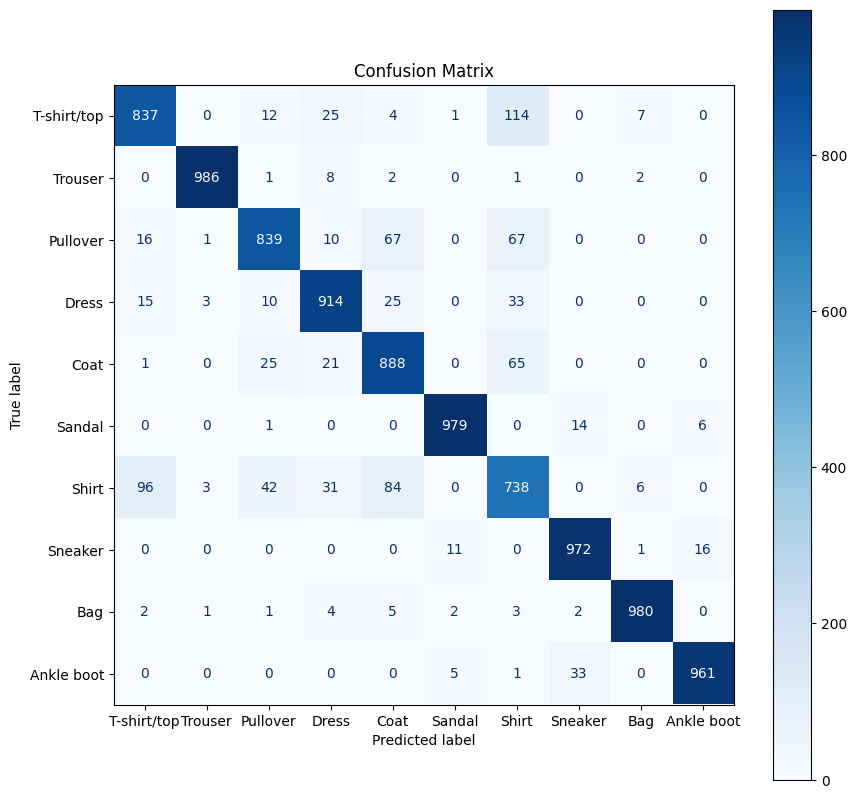

In [95]:
FashionModel.eval()
loss, acc = 0, 0

# Lists to store ALL predictions and ALL true labels
all_preds = []
all_labels = []

with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_logits = FashionModel(X)
        y_pred = y_logits.argmax(dim=1) # Convert logits to class labels

        # Calculate Loss & Accuracy (Running average)
        loss += loss_fn(y_logits, y).item()
        acc += accuracy_fn(y_true=y, y_pred=y_pred)

        # 2. Store predictions/labels for later (Move to CPU first!)
        all_preds.append(y_pred.cpu())
        all_labels.append(y.cpu())

# Calculate average loss/acc
loss /= len(test_dataloader)
acc /= len(test_dataloader)

# Concatenate all batches into single tensors
all_preds_tensor = torch.cat(all_preds)
all_labels_tensor = torch.cat(all_labels)

# Calculate Metrics using Scikit-Learn with 
print(f"\nModel Results:\nLoss: {loss:.4f} | Accuracy: {acc:.2f}%")

print("\nClassification Report (Precision, Recall, F1):")
print(classification_report(all_labels_tensor, all_preds_tensor))

# Plot Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels_tensor, all_preds_tensor)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix")
plt.show()

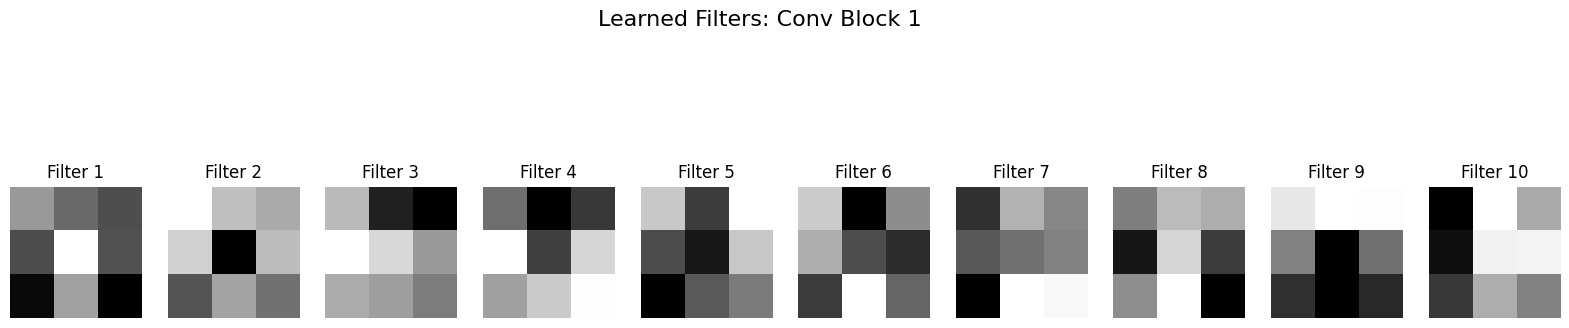

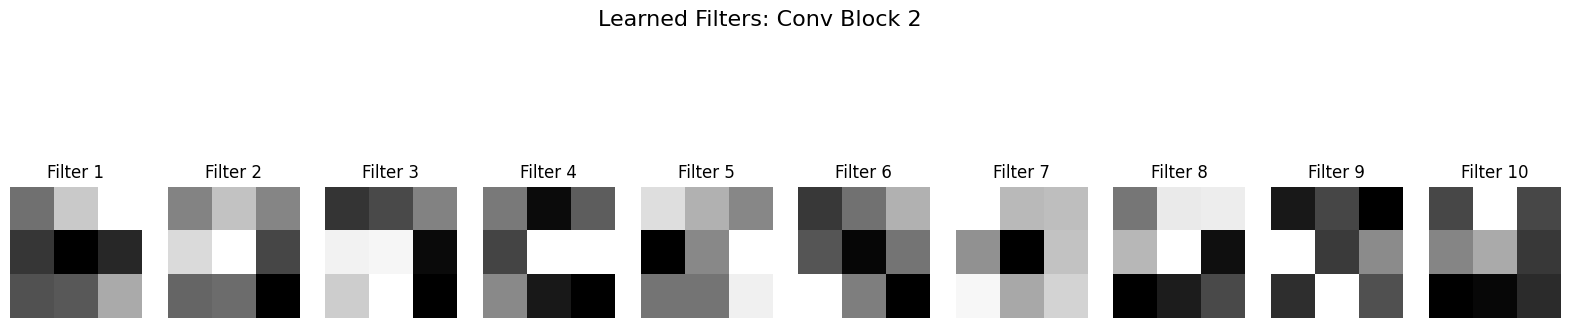

In [96]:
def visualize_filters(model):
    # 1. Define the layers we want to visualize
    layers_to_viz = [
        ("Conv Block 1", model.conv_block_1[0].weight.data.cpu().numpy()),
        ("Conv Block 2", model.conv_block_2[0].weight.data.cpu().numpy())
    ]

    for layer_name, filters in layers_to_viz:
        # filters shape: [out_channels, in_channels, kernel_h, kernel_w]
        num_filters = filters.shape[0]
        
        # Create a new figure for this layer
        fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))
        fig.suptitle(f'Learned Filters: {layer_name}', fontsize=16)
        
        for i in range(num_filters):
            # We select the ith filter.
            # We select channel 0 (index 1) to make it 2D.
            # For Layer 1: Shape is [1, 3, 3] -> We take the only channel.
            # For Layer 2: Shape is [10, 3, 3] -> We take the first channel of the stack.
            f = filters[i, 0, :, :]
            
            # Plot
            ax = axes[i]
            ax.imshow(f, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Filter {i+1}')
            
        plt.show()

visualize_filters(FashionModel)

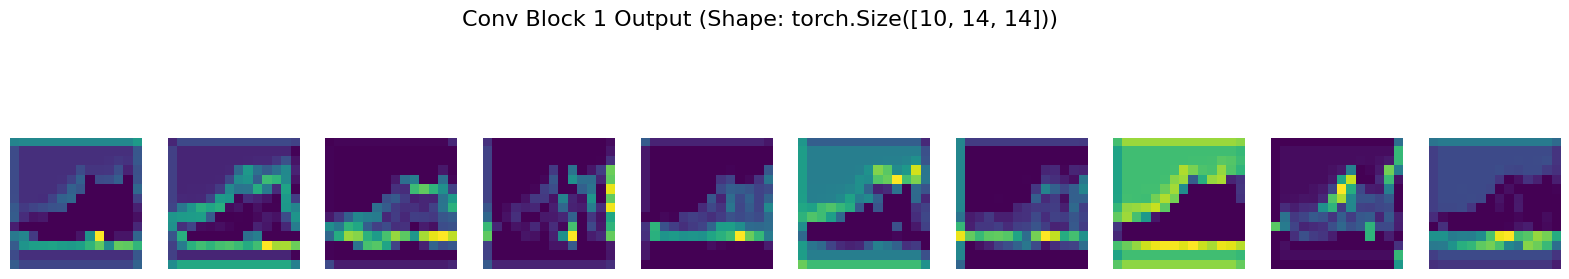

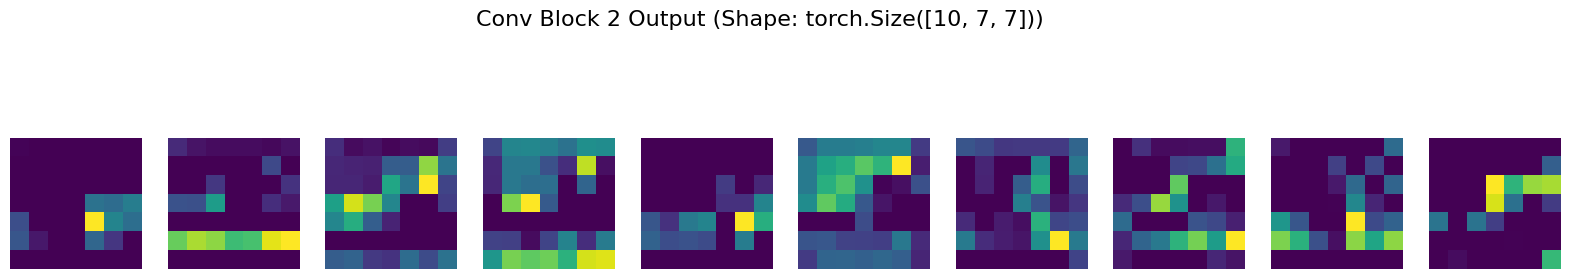

In [94]:
def visualize_feature_maps(model, image, device):
    model.eval()
    
    # 1. Prepare image
    # Add batch dimension: [1, 28, 28] -> [1, 1, 28, 28]
    x = image.unsqueeze(0).to(device)
    
    feature_maps = []
    layer_names = []
    
    # 2. Pass through Conv Block 1
    x = model.conv_block_1(x)
    feature_maps.append(x)
    layer_names.append("Conv Block 1 Output")
    
    # 3. Pass through Conv Block 2
    x = model.conv_block_2(x)
    feature_maps.append(x)
    layer_names.append("Conv Block 2 Output")
    
    # 4. Plotting Loop
    for layer_idx, f_map in enumerate(feature_maps):
        # Remove batch dimension: [1, 10, 14, 14] -> [10, 14, 14]
        f_map = f_map.squeeze(0).detach().cpu()
        
        num_channels = f_map.shape[0]
        
        # Create a grid for the plot
        fig, axes = plt.subplots(1, num_channels, figsize=(20, 4))
        fig.suptitle(f'{layer_names[layer_idx]} (Shape: {f_map.shape})', fontsize=16)
        
        for i in range(num_channels):
            ax = axes[i]
            ax.imshow(f_map[i], cmap='viridis') # 'viridis' is good for activation heatmaps
            ax.axis('off')
            
        plt.show()

# Run the function with a sample image from the test set
# Get a single image
sample_img, label = test_data[0] 

visualize_feature_maps(FashionModel, sample_img, device)

### Hyperparameter Tuning

I experimented with several configurations to balance model stability and learning speed. I initially started with a smaller batch size and a lower learning rate, but the model converged too slowly. I found that increasing the learning rate to **0.1** and the batch size to **64** sped up training significantly. To refine the final result, I introduced a `StepLR` scheduler with a gamma of **0.5**. This allowed the model to learn rapidly in the early epochs and then settle more precisely into a minimum by halving the learning rate every 3 epochs, which consistently gave me the best test accuracy.

### Report

#### 1. Summary

I built a custom CNN based on the TinyVGG architecture to classify the FashionMNIST dataset. I normalized the data using calculated mean and standard deviation statistics and trained the model using SGD with a learning rate of 0.1. To improve convergence, I implemented a `StepLR` scheduler that reduced the learning rate every 3 epochs. Evaluation included tracking loss curves, calculating precision/recall, and analyzing the confusion matrix.

#### 2. Analysis & Findings

* **Performance:** The model converged well, with the scheduler helping to fine-tune accuracy in later epochs. The architecture proved efficient for this dataset size.
* **Challenges:** The main difficulty was distinguishing between similar upper-body garments. The Confusion Matrix showed that **Shirts, T-shirts, Pullovers, and Coats** were most frequently confused with each other due to their similar shapes.
* **Visualizations:**
* **Filters:** The visualizations confirmed that the first layer learned standard edge detectors (lines and gradients).
* **Feature Maps:** These showed the network successfully isolating the clothing items from the background, with deeper layers capturing more abstract textures rather than exact shapes.